# Confidence envelopes for ROC curves

A ROC curve $\mathrm{Roc}:[0,1]\to[0,1]$ packs a lot of information about a classifer. 
In particular, it allows to choose good trade-off points between recall and precision, or compare the performance of different classifiers.
Note that we cannot compute the true ROC curve as it is determined by the exact data distributions of positive and negative classes.
Instead we can only compute the approximation on a test set and thus the graph is bound to fluctuate.
By computing the confidence envelopes, we could characterise the uncertainty.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import numpy.random as rnd

from pandas import Series
from pandas import DataFrame
from pandas import concat

from statsmodels.stats.proportion import proportion_confint

from tqdm import tnrange
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Theoretical model behind the ROC curve

First note that the ideal ROC curve is given by the following parametric equation

\begin{align*}
\begin{cases}
\alpha(\tau) = \Pr[\boldsymbol{x}\gets\mathcal{D}_{-}: f(\boldsymbol{x})\geq \tau]\\
\beta(\tau) = \Pr[\boldsymbol{x}\gets\mathcal{D}_{+}: f(\boldsymbol{x})\geq \tau]\enspace,
\end{cases}
\end{align*}

where 
* $\mathcal{D}_{+}$ and $\mathcal{D}_{-}$ are the data distributions of positive and negative cases, respectively
* $f(\boldsymbol{x})$ is the decision value assigned to data point $\boldsymbol{x}$
* $\tau$ is the threshold above which all decision values are declared as positive

From this definition it is easy to see that $\alpha(\tau)$ is the ratio of false positives and $\beta(\tau)$ is the ratio of true positives in a setting where the number of test samples is infinite. 

In practice we observe $N$ negative samples and $P$ positive samples in the test set. If all the test samples are iid then  
* all the negative samples are iid samples from $\mathcal{D}_{-}$
* all the positive samples are iid samples from $\mathcal{D}_{+}$

Thus the number of false positives $\mathrm{FP}$ and true positives $\mathrm{TP}$ are distributed according to binomial distributions: 

\begin{align*}
\mathrm{FP}&\sim\mathrm{Bin}(n=N, p=\alpha(\tau))\\
\mathrm{TP}&\sim\mathrm{Bin}(n=P, p=\beta(\tau))
\end{align*}

As the number of true and false positives are independent if the number of negative and positive cases are fixed, it is straightforward to assign a probability to the pair $(\mathrm{FP},\mathrm{TP})$.

### Example visualisation for ROC curve points

Let us consider a particular theoretical ROC curve given by equation $\alpha=2\beta-\beta^2$ and let us simulate the corresponding ROC curves for $n$-element test set. 
* This is difficult to do correctly as different measurements on the ROC curve are not indepentent. 
* That is if the previuos point on the ROC curve is above the true line then the next point is also likely to be over line.

Hence, we simulate the unrealistic case where one uses independent test sets for each data point. 
* The latter correctly mimics the variance of individual points on a ROC curve but fails to correctly model ROC curves.     


In [2]:
k = 50
roc = DataFrame({'beta': np.linspace(0, 1, 100)}).assign(alpha = lambda df: 2 * df['beta'] - df['beta']**2)

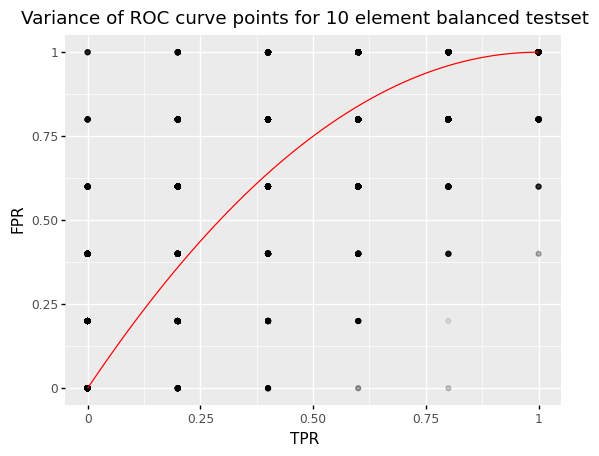

<ggplot: (351398783)>

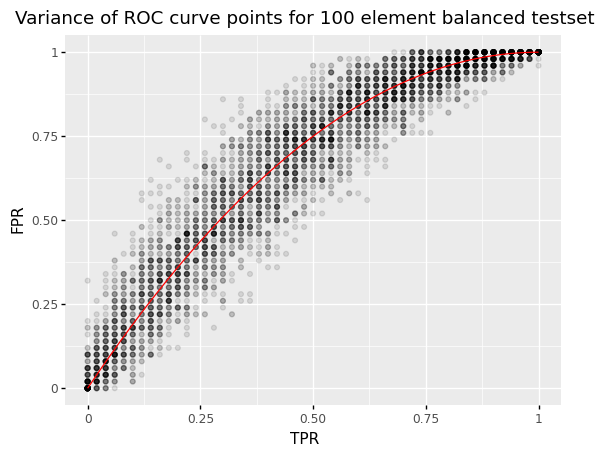

<ggplot: (351378158)>

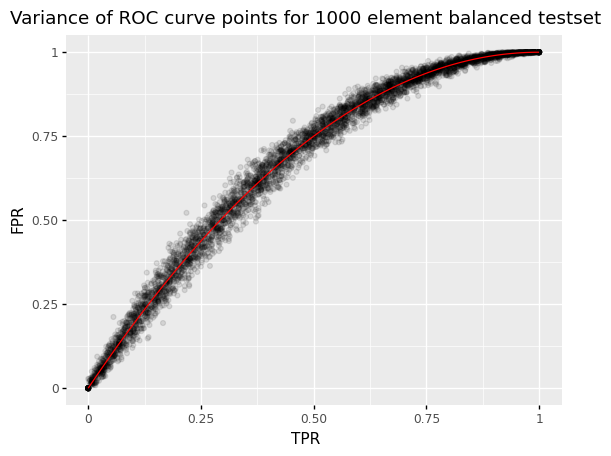

<ggplot: (351580136)>

In [3]:
n = 5
observations = []
for row in roc.itertuples():
    observations.append(DataFrame({'FPR': rnd.binomial(n=n, p=row.alpha, size=k)/n, 'TPR': rnd.binomial(n=n, p=row.beta, size=k)/n}))    

df = concat(observations, axis=0)
p = ggplot(df) + geom_point(aes(x='TPR', y='FPR'), alpha=0.1)
p = p + geom_line(aes(x='beta', y='alpha'), data=roc, color='red')
p = p + ggtitle(f'Variance of ROC curve points for {2 * n} element balanced testset')
display(p)

n = 50
observations = []
for row in roc.itertuples():
    observations.append(DataFrame({'FPR': rnd.binomial(n=n, p=row.alpha, size=k)/n, 'TPR': rnd.binomial(n=n, p=row.beta, size=k)/n}))    

df = concat(observations, axis=0)
p = ggplot(df) + geom_point(aes(x='TPR', y='FPR'), alpha=0.1)
p = p + geom_line(aes(x='beta', y='alpha'), data=roc, color='red')
p = p + ggtitle(f'Variance of ROC curve points for {2 * n} element balanced testset')
display(p)

n = 500
observations = []
for row in roc.itertuples():
    observations.append(DataFrame({'FPR': rnd.binomial(n=n, p=row.alpha, size=k)/n, 'TPR': rnd.binomial(n=n, p=row.beta, size=k)/n}))    

df = concat(observations, axis=0)
p = ggplot(df) + geom_point(aes(x='TPR', y='FPR'), alpha=0.1)
p = p + geom_line(aes(x='beta', y='alpha'), data=roc, color='red')
p = p + ggtitle(f'Variance of ROC curve points for {2 * n} element balanced testset')
display(p)

### Example visualisation for ROC curves lines

The simulation of ROC curve lines is much more difficult as different points on the ROC curve are correlated. Therefore, one needs to reverse-engineer the $f(\boldsymbol{x})$ distribution for $\mathcal{D}_{+}$ and $\mathcal{D}_{-}$ sets and then simulate $f(\boldsymbol{x})$ values to the entire test set simultaneously. As this is diffificult do the opposite:
* We fix distributions for $f(\boldsymbol{x})$.
* We approximate the corresponding ideal ROC curve by using CDF function.

In [4]:
from scipy.stats import beta

In [5]:
dist_neg = beta(2, 5)
dist_pos = beta(4, 5)

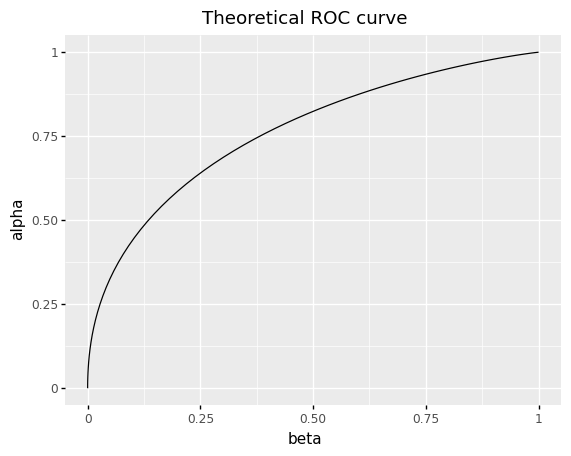

<ggplot: (276979472)>

In [6]:
roc = (DataFrame({'tau': np.linspace(0, 1, 100)})
       .assign(alpha = lambda df: dist_neg.cdf(df['tau']))
       .assign(beta = lambda df: dist_pos.cdf(df['tau'])))
ggplot(roc) + geom_line(aes(x='beta',y='alpha')) + ggtitle('Theoretical ROC curve')

In [7]:
k = 50

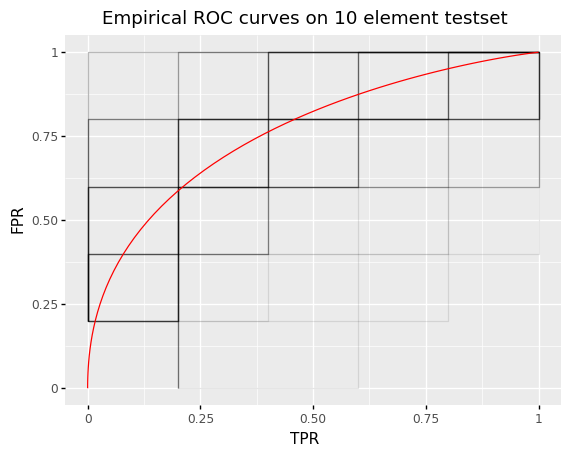

<ggplot: (351576724)>

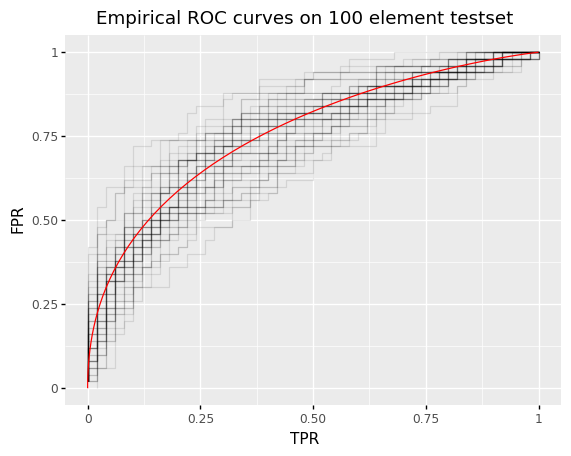

<ggplot: (369260538)>

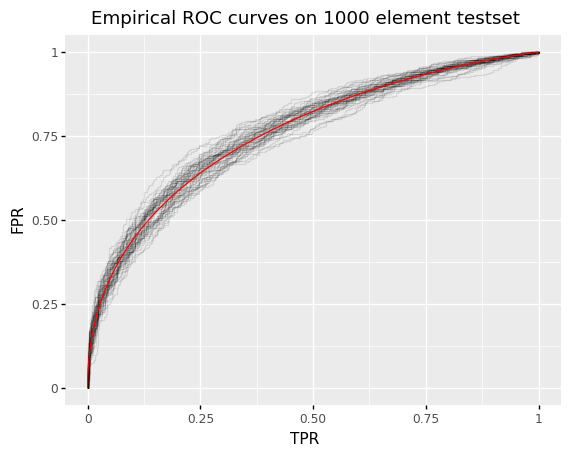

<ggplot: (351572881)>

In [8]:
n = 5
observations = []
for i in range(k):
    data = (concat([
        DataFrame({'f': dist_neg.rvs(n)}).assign(label='-'), 
        DataFrame({'f': dist_pos.rvs(n)}).assign(label='+')], axis=0)
        .sort_values(['f']))
    observations.append(DataFrame({
        'TPR': np.cumsum(data['label'] == '+')/n, 
        'FPR': np.cumsum(data['label'] == '-')/n})
        .assign(exp = i))

df = concat(observations, axis=0)
p = ggplot(df) + geom_line(aes(x='TPR', y='FPR', group='exp'), alpha=0.1) 
p = p + geom_line(aes(x='beta',y='alpha'), data=roc, color='red') 
p = p + ggtitle(f'Empirical ROC curves on {2*n} element testset')
display(p)

n = 50
observations = []
for i in range(k):
    data = (concat([
        DataFrame({'f': dist_neg.rvs(n)}).assign(label='-'), 
        DataFrame({'f': dist_pos.rvs(n)}).assign(label='+')], axis=0)
        .sort_values(['f']))
    observations.append(DataFrame({
        'TPR': np.cumsum(data['label'] == '+')/n, 
        'FPR': np.cumsum(data['label'] == '-')/n})
        .assign(exp = i))

df = concat(observations, axis=0)
p = ggplot(df) + geom_line(aes(x='TPR', y='FPR', group='exp'), alpha=0.1) 
p = p + geom_line(aes(x='beta',y='alpha'), data=roc, color='red') 
p = p + ggtitle(f'Empirical ROC curves on {2*n} element testset')
display(p)

n = 500
observations = []
for i in range(k):
    data = (concat([
        DataFrame({'f': dist_neg.rvs(n)}).assign(label='-'), 
        DataFrame({'f': dist_pos.rvs(n)}).assign(label='+')], axis=0)
        .sort_values(['f']))
    observations.append(DataFrame({
        'TPR': np.cumsum(data['label'] == '+')/n, 
        'FPR': np.cumsum(data['label'] == '-')/n})
        .assign(exp = i))

df = concat(observations, axis=0)
p = ggplot(df) + geom_line(aes(x='TPR', y='FPR', group='exp'), alpha=0.1) 
p = p + geom_line(aes(x='beta',y='alpha'), data=roc, color='red') 
p = p + ggtitle(f'Empirical ROC curves on {2*n} element testset')
display(p)


### Example visualisation for unbalanced testset

All graphs simulated above we defined under the assumption that the number of true positives and true negatives is the same. Im many cases the number of true positives is much smaller than the number of true negatives. The following figures capture its impact on the ROC curves.

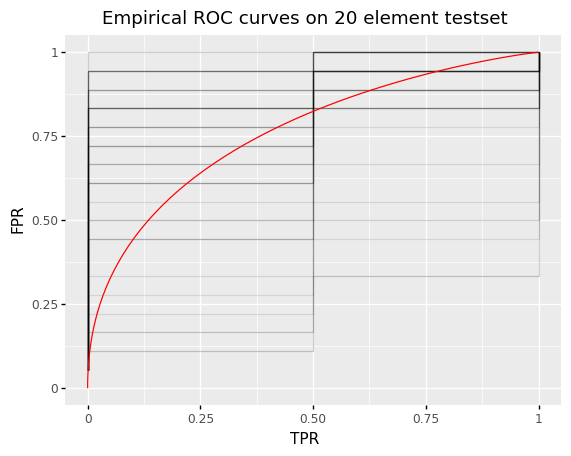

<ggplot: (369456637)>

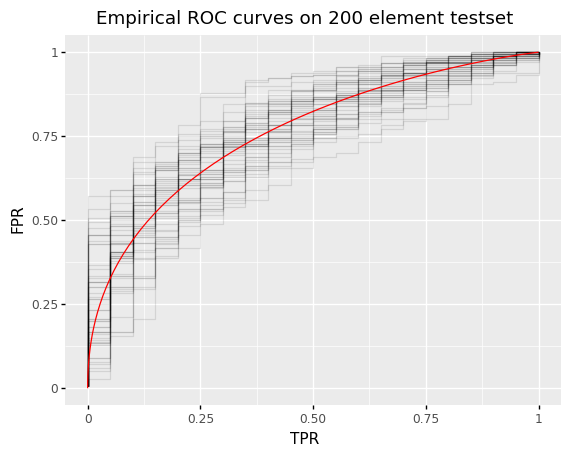

<ggplot: (369535997)>

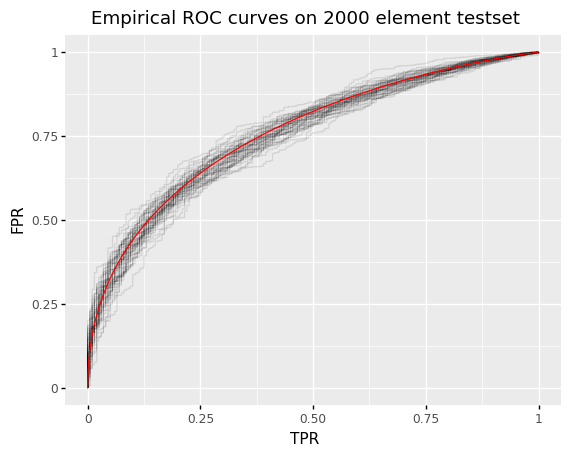

<ggplot: (369614333)>

In [9]:
n_pos = 2
n_neg = 18
observations = []
for i in range(k):
    data = (concat([
        DataFrame({'f': dist_neg.rvs(n_neg)}).assign(label='-'), 
        DataFrame({'f': dist_pos.rvs(n_pos)}).assign(label='+')], axis=0)
        .sort_values(['f']))
    observations.append(DataFrame({
        'TPR': np.cumsum(data['label'] == '+')/n_pos, 
        'FPR': np.cumsum(data['label'] == '-')/n_neg})
        .assign(exp = i))

df = concat(observations, axis=0)
p = ggplot(df) + geom_line(aes(x='TPR', y='FPR', group='exp'), alpha=0.1) 
p = p + geom_line(aes(x='beta',y='alpha'), data=roc, color='red') 
p = p + ggtitle(f'Empirical ROC curves on {n_pos + n_neg} element testset')
display(p)

n_pos = 20
n_neg = 180
observations = []
for i in range(k):
    data = (concat([
        DataFrame({'f': dist_neg.rvs(n_neg)}).assign(label='-'), 
        DataFrame({'f': dist_pos.rvs(n_pos)}).assign(label='+')], axis=0)
        .sort_values(['f']))
    observations.append(DataFrame({
        'TPR': np.cumsum(data['label'] == '+')/n_pos, 
        'FPR': np.cumsum(data['label'] == '-')/n_neg})
        .assign(exp = i))

df = concat(observations, axis=0)
p = ggplot(df) + geom_line(aes(x='TPR', y='FPR', group='exp'), alpha=0.1) 
p = p + geom_line(aes(x='beta',y='alpha'), data=roc, color='red') 
p = p + ggtitle(f'Empirical ROC curves on {n_pos + n_neg} element testset')
display(p)

n_pos = 200
n_neg = 1800
observations = []
for i in range(k):
    data = (concat([
        DataFrame({'f': dist_neg.rvs(n_neg)}).assign(label='-'), 
        DataFrame({'f': dist_pos.rvs(n_pos)}).assign(label='+')], axis=0)
        .sort_values(['f']))
    observations.append(DataFrame({
        'TPR': np.cumsum(data['label'] == '+')/n_pos, 
        'FPR': np.cumsum(data['label'] == '-')/n_neg})
        .assign(exp = i))

df = concat(observations, axis=0)
p = ggplot(df) + geom_line(aes(x='TPR', y='FPR', group='exp'), alpha=0.1) 
p = p + geom_line(aes(x='beta',y='alpha'), data=roc, color='red') 
p = p + ggtitle(f'Empirical ROC curves on {n_pos + n_neg} element testset')
display(p)



## II. How to define a statistical test for the pair of ratios

In order to get further, we must define a single test statistic for which we can compute the probability. This will determine how narrow will be the confidence envelope for the ROC curve, hence we must be careful. There are three natural ways to define the test statistic.

### The acceptance region will be a square box

Given parameters $N$, $P$, $\alpha$, $\beta$, we can easily compute the probability assigned to the square box centered around the expected values of $FP$ and $TP$:  

\begin{align*}
f(\Delta_1,\Delta_2)= \Pr[|FP-N\alpha|\leq \Delta_1\wedge |TP-P\beta|\leq \Delta_2]
\end{align*}

Minimising $\Delta_1$ and $\Delta_2$ such that $f(\Delta_1,\Delta_2)\geq 1-\rho$, where $\rho$ is the desired significance level, will give us a statistical test.


### The acceptance region will be the cells with maximal probability

As we can compute the probability for any $(FP, TP)$ pair, we can order them and reject the tail with weight $\rho$. This will be a slightly more powerful test as we accept the region of the highest probability mass, i.e., the points that are typical to the distribution.


### Acceptance region will be an ellips determined by a normal approximation

Note that for moderately large values of $N$ and $P$, the binomial distribution converges to a normal distribution. 
As $FP$ and $NP$ are independent, we can approximate $(FP,TP)$ by a normal distribution where only the diagonals contain non-zero entries. By proper scaling, we can make sure that $(\gamma_1\cdot FP,\gamma_2\cdot TP)$ can be approximated with white Gaussian noise $\mathcal{N}(0, I)$. For that distribution the best test statistic is distance squared
$\gamma_1^2\cdot FP^2 +\gamma_2^2\cdot TP^2$, which is distributed according to a $\chi^2$-distribution with two degrees of freedom. This gives rise to another test.

### Example analysis

Lets use the standard confidence intervals for both axis separately and see wether the the theoretical ROC curve goes throught the acceptance regions.

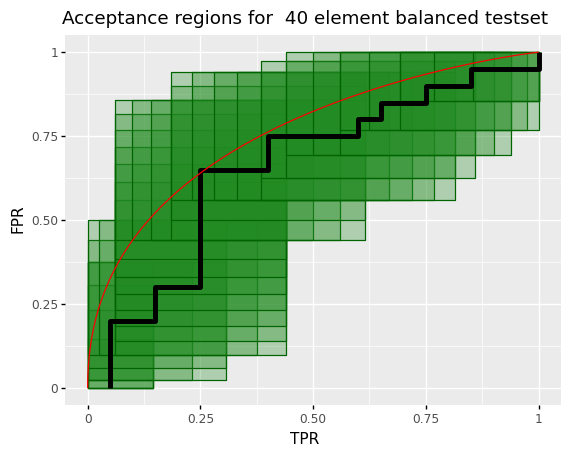

<ggplot: (371799399)>

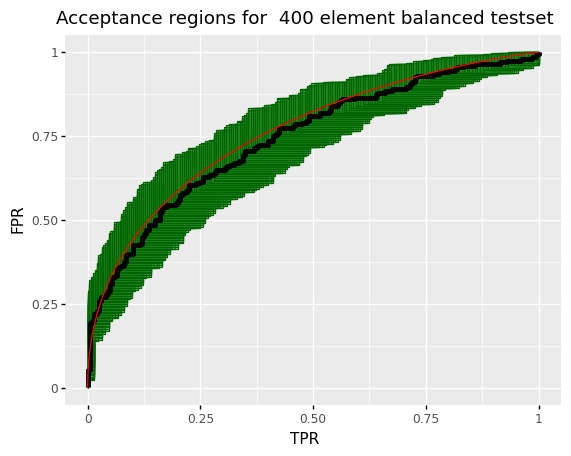

<ggplot: (371838347)>

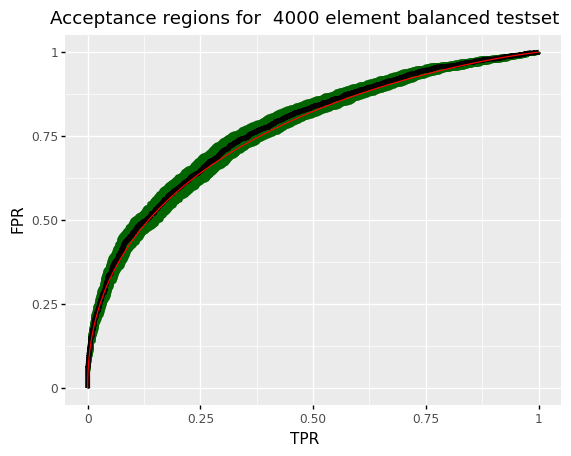

<ggplot: (371839708)>

In [10]:
roc = (DataFrame({'tau': np.linspace(0, 1, 100)})
       .assign(alpha = lambda df: dist_neg.cdf(df['tau']))
       .assign(beta = lambda df: dist_pos.cdf(df['tau'])))


n = 20
data = (concat([
    DataFrame({'f': dist_neg.rvs(n)}).assign(label='-'), 
    DataFrame({'f': dist_pos.rvs(n)}).assign(label='+')], axis=0)
    .sort_values(['f']))

emp_roc = DataFrame({
    'TPC': np.cumsum(data['label'] == '+'), 
    'FPC': np.cumsum(data['label'] == '-'),
    'TPR': np.cumsum(data['label'] == '+')/n, 
    'FPR': np.cumsum(data['label'] == '-')/n,
})

pdf = DataFrame({
    'beta_0': emp_roc['TPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[0]),
    'beta_1': emp_roc['TPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[1]),
    'alpha_0': emp_roc['FPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[0]),
    'alpha_1': emp_roc['FPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[1])
})

p = ggplot(pdf) 
p = p + geom_rect(aes(xmin='beta_0', xmax='beta_1', ymin='alpha_0', ymax='alpha_1'), alpha=0.3, fill='forestgreen', color='darkgreen')
p = p + geom_line(aes(x='TPR', y='FPR'), data=emp_roc, color='black', size=2)
p = p + geom_line(aes(x='beta',y='alpha'), data=roc, color='red') 
p = p + ggtitle(f'Acceptance regions for  {2 * n} element balanced testset')
display(p)

n = 200
data = (concat([
    DataFrame({'f': dist_neg.rvs(n)}).assign(label='-'), 
    DataFrame({'f': dist_pos.rvs(n)}).assign(label='+')], axis=0)
    .sort_values(['f']))

emp_roc = DataFrame({
    'TPC': np.cumsum(data['label'] == '+'), 
    'FPC': np.cumsum(data['label'] == '-'),
    'TPR': np.cumsum(data['label'] == '+')/n, 
    'FPR': np.cumsum(data['label'] == '-')/n,
})

pdf = DataFrame({
    'beta_0': emp_roc['TPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[0]),
    'beta_1': emp_roc['TPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[1]),
    'alpha_0': emp_roc['FPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[0]),
    'alpha_1': emp_roc['FPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[1])
})

p = ggplot(pdf) 
p = p + geom_rect(aes(xmin='beta_0', xmax='beta_1', ymin='alpha_0', ymax='alpha_1'), alpha=0.3, fill='forestgreen', color='darkgreen')
p = p + geom_line(aes(x='TPR', y='FPR'), data=emp_roc, color='black', size=2)
p = p + geom_line(aes(x='beta',y='alpha'), data=roc, color='red') 
p = p + ggtitle(f'Acceptance regions for  {2 * n} element balanced testset')
display(p)

n = 2000
data = (concat([
    DataFrame({'f': dist_neg.rvs(n)}).assign(label='-'), 
    DataFrame({'f': dist_pos.rvs(n)}).assign(label='+')], axis=0)
    .sort_values(['f']))

emp_roc = DataFrame({
    'TPC': np.cumsum(data['label'] == '+'), 
    'FPC': np.cumsum(data['label'] == '-'),
    'TPR': np.cumsum(data['label'] == '+')/n, 
    'FPR': np.cumsum(data['label'] == '-')/n,
})

pdf = DataFrame({
    'beta_0': emp_roc['TPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[0]),
    'beta_1': emp_roc['TPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[1]),
    'alpha_0': emp_roc['FPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[0]),
    'alpha_1': emp_roc['FPC'].apply(lambda x: proportion_confint(x, nobs=n, alpha=0.05)[1])
})

p = ggplot(pdf) 
p = p + geom_rect(aes(xmin='beta_0', xmax='beta_1', ymin='alpha_0', ymax='alpha_1'), alpha=0.3, fill='forestgreen', color='darkgreen')
p = p + geom_line(aes(x='TPR', y='FPR'), data=emp_roc, color='black', size=2)
p = p + geom_line(aes(x='beta',y='alpha'), data=roc, color='red') 
p = p + ggtitle(f'Acceptance regions for  {2 * n} element balanced testset')
display(p)

# Homework

## 4.1 Compare tests for the pair of ratios* (<font color='red'>3p</font>)  

Implement all of the three tests and compare their acceptance regions for the case $N=P$ and $N\in\{10, 50, 100, 1000\}$.
Compare the power of these tests by considering the hypotheses $(\alpha,\beta)$ and $(\alpha+\delta, \beta+\delta)$:
* for some reasonable $\delta$ values in the range $[0, 0.1]$
* for some reasonable $\alpha, \beta$ values in the box $[0,1]\times[0,1]$

Can you decide which test is the best to use in computing confidence intervals for comparing hypotheses $(\alpha,\beta)$ and $(\alpha+\delta_1, \beta+\delta_2)$?

## 4.2 Build  a confidence envelope for the ROC curve* (<font color='red'>3p</font>)  

Use the naive grid testing approach to build a confidence envelope:
* For each $(FP,TP)$ pair in the empirical ROC curve compute the acceptance region for $(\alpha_i,\beta_i)$.
* Merge all the acceptance regions and compute convex hull around it.
* Declare the result as the confidence envelope.

Test whether the construction gives indeed a pointwise confidence envelope. For each $(FP,TP)$ pair the corresponding estimate $FP/N,TP/P$ is guaranteed to be in the envelope with confidence at least $1-\rho$ by construction, but if individual regions overlap the confidence can be much larger. 

In [11]:
%config IPCompleter.greedy=True